=== ANÁLISIS COMPARATIVO DE MODELOS ===

Mejor modelo encontrado: SARIMA(0, 2, 2)(2, 1, 0, 12)
AIC: 1284.53

=== MODELO 1: SARIMA ESTÁTICO ===
RMSE: 1569.32
MAPE: 0.2814 (28.14%)

=== MODELO 2: SARIMA ROLLING ===
RMSE: 988.51
MAPE: 0.1665 (16.65%)

=== PREDICCIONES FUTURAS 2024 ===
Comparando ambos enfoques:

OPCIÓN 1: Modelo estático entrenado con todos los datos
OPCIÓN 2: Continuar con enfoque rolling

Predicciones para 2024:
Mes		Estático	Rolling		Diferencia
-------------------------------------------------------
2024-01		4947		6135		+1187
2024-02		5464		6505		+1041
2024-03		6418		7538		+1121
2024-04		5430		6826		+1396
2024-05		5937		7654		+1717
2024-06		7055		9047		+1991
2024-07		5623		7178		+1556
2024-08		5371		7589		+2218
2024-09		6592		8608		+2016
2024-10		6922		9331		+2409
2024-11		7604		10315		+2710
2024-12		7760		10874		+3115

=== COMPARACIÓN FINAL ===
Rendimiento en 2023:
Modelo Estático  - RMSE: 1569.32, MAPE: 28.14%
Modelo Rolling   - RMSE: 988.51, MAPE: 16.65%
Mejora Roll

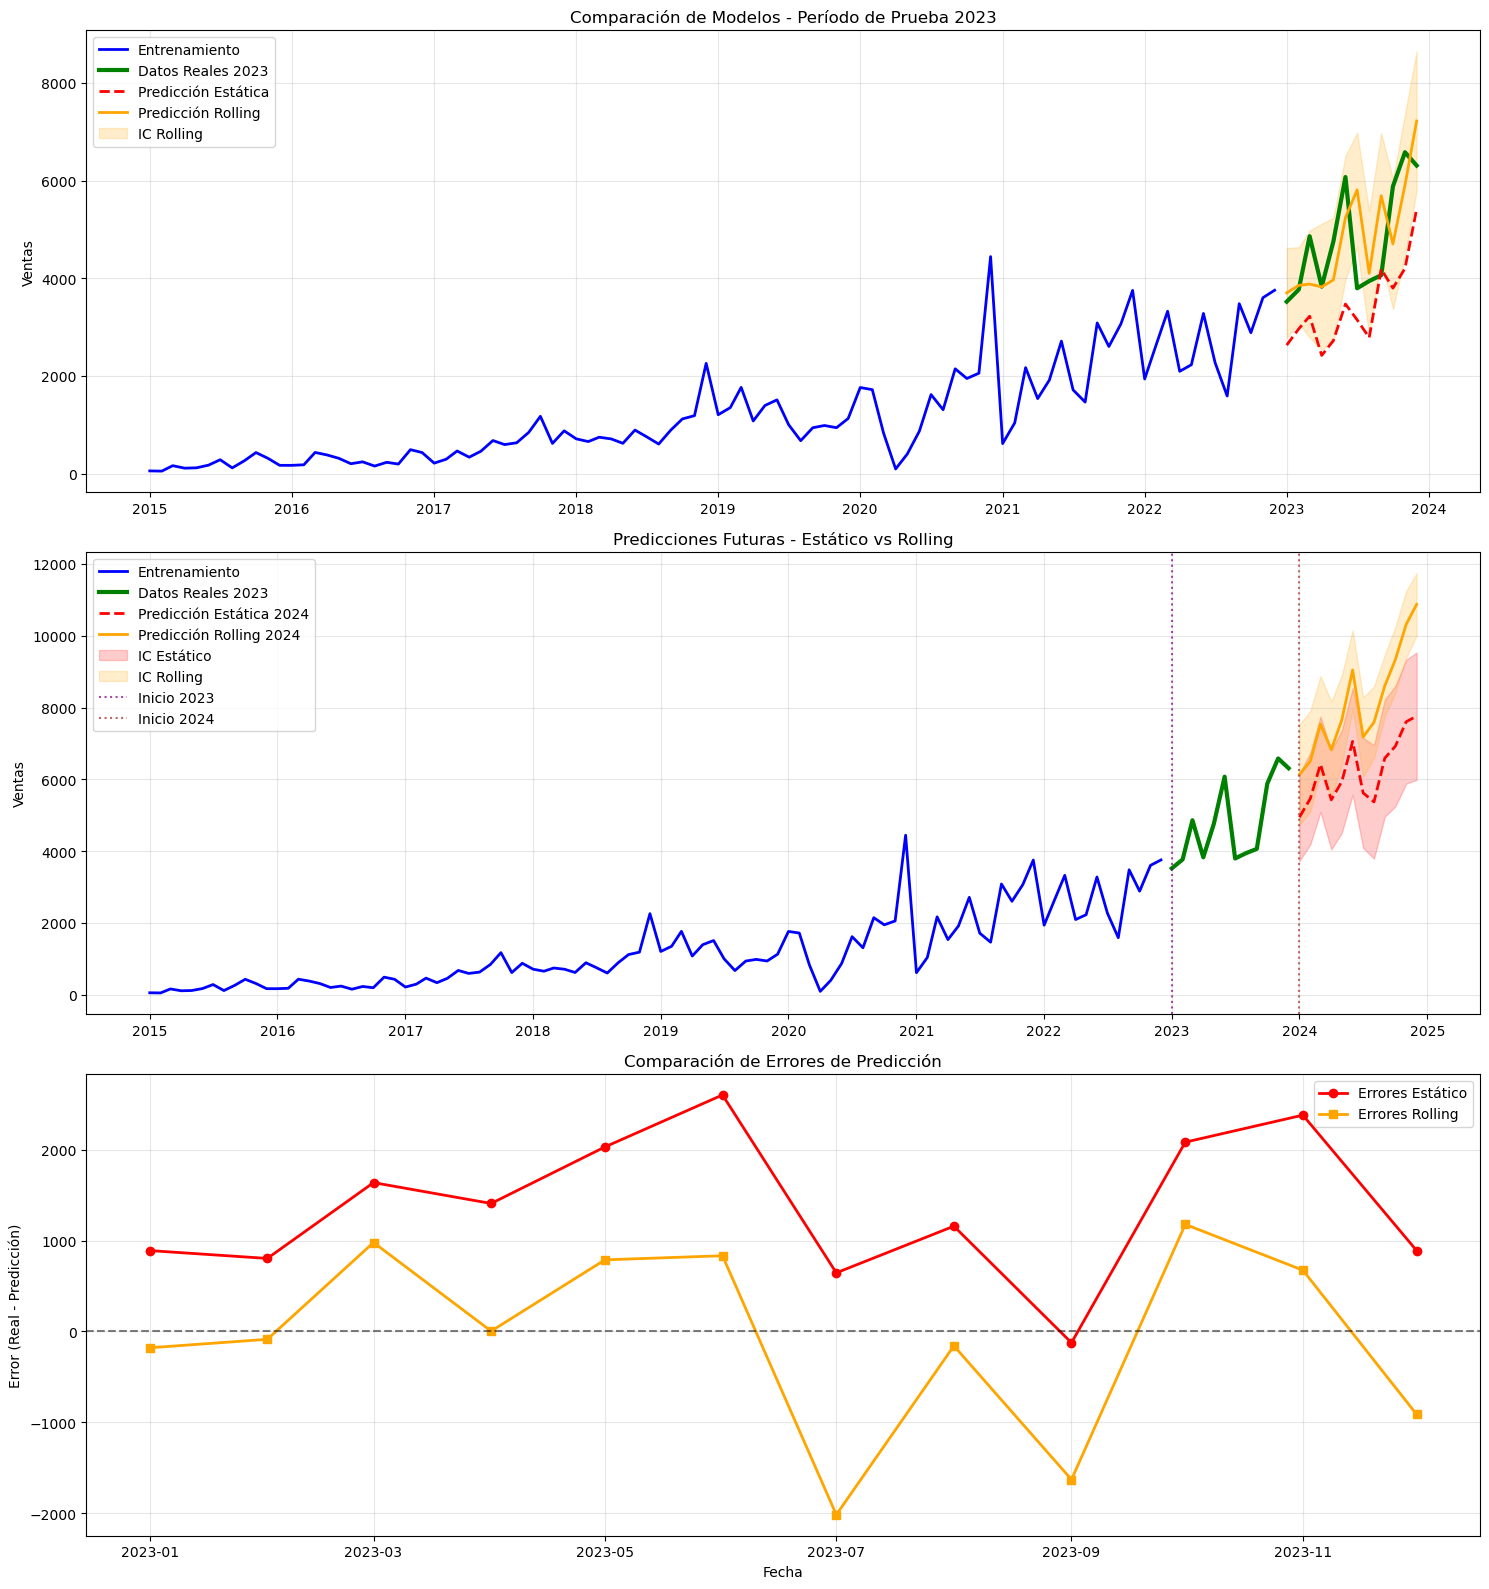


=== RECOMENDACIÓN FINAL ===
✅ EL MODELO ROLLING ES SUPERIOR Y RECOMENDADO
• Mejor precisión: 16.7% MAPE vs 28.1%
• Se adapta mejor a cambios de tendencia
• Más apropiado para mercados dinámicos como vehículos eléctricos
• Para predicciones futuras: usar enfoque rolling consistente


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Cargar los datos
data = pd.read_excel('exports/ts_final.xlsx')
data['fecha'] = pd.to_datetime(data['ANO'].astype(str) + '-' + data['MES'].astype(str) + '-01')
data.set_index('fecha', inplace=True)
ts = data['ventas_electrico']

# Dividir en entrenamiento y prueba
train = ts[:'2022-12-01']
test = ts['2023-01-01':]

print("=== ANÁLISIS COMPARATIVO DE MODELOS ===\n")

# Búsqueda automática de parámetros (versión rápida)
def quick_sarima_search(train_data, max_p=2, max_d=2, max_q=2, max_P=2, max_D=1, max_Q=1, s=12):
    """Búsqueda rápida de parámetros SARIMA"""
    best_aic = float('inf')
    best_params = None
    best_seasonal_params = None
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                for P in range(max_P + 1):
                    for D in range(max_D + 1):
                        for Q in range(max_Q + 1):
                            try:
                                model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
                                fitted_model = model.fit(disp=False)
                                if fitted_model.aic < best_aic:
                                    best_aic = fitted_model.aic
                                    best_params = (p, d, q)
                                    best_seasonal_params = (P, D, Q, s)
                            except:
                                continue
    
    return best_params, best_seasonal_params, best_aic

# Encontrar mejores parámetros
best_order, best_seasonal_order, best_aic = quick_sarima_search(train)
print(f"Mejor modelo encontrado: SARIMA{best_order}{best_seasonal_order}")
print(f"AIC: {best_aic:.2f}\n")

# === MODELO 1: SARIMA ESTÁTICO ===
print("=== MODELO 1: SARIMA ESTÁTICO ===")
static_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
static_fit = static_model.fit(disp=False)

# Predicciones estáticas
static_pred = static_fit.get_forecast(steps=len(test))
static_pred_mean = static_pred.predicted_mean
static_pred_ci = static_pred.conf_int()

# Métricas estáticas
static_rmse = np.sqrt(mean_squared_error(test, static_pred_mean))
static_mape = mean_absolute_percentage_error(test, static_pred_mean)
print(f"RMSE: {static_rmse:.2f}")
print(f"MAPE: {static_mape:.4f} ({static_mape*100:.2f}%)\n")

# === MODELO 2: SARIMA ROLLING ===
print("=== MODELO 2: SARIMA ROLLING ===")

def rolling_forecast_detailed(train_data, test_data, order, seasonal_order, window_size=36):
    """Predicción rolling con detalles"""
    predictions = []
    confidence_intervals = []
    
    # Crear serie completa que se irá actualizando
    full_series = train_data.copy()
    
    for i in range(len(test_data)):
        # Usar ventana deslizante
        if len(full_series) > window_size:
            train_window = full_series[-window_size:]
        else:
            train_window = full_series
        
        try:
            # Ajustar modelo
            model = SARIMAX(train_window, order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            
            # Predecir siguiente punto
            pred = model_fit.get_forecast(steps=1)
            predictions.append(pred.predicted_mean.iloc[0])
            confidence_intervals.append([pred.conf_int().iloc[0, 0], pred.conf_int().iloc[0, 1]])
            
        except:
            # Si falla, usar la media de las últimas observaciones
            predictions.append(train_window.iloc[-3:].mean())
            confidence_intervals.append([predictions[-1] * 0.8, predictions[-1] * 1.2])
        
        # Actualizar serie completa con valor real
        full_series = pd.concat([full_series, test_data.iloc[i:i+1]])
    
    # Convertir a Series y DataFrame
    pred_series = pd.Series(predictions, index=test_data.index)
    ci_df = pd.DataFrame(confidence_intervals, index=test_data.index, columns=['lower', 'upper'])
    
    return pred_series, ci_df, full_series

# Aplicar rolling
rolling_pred, rolling_ci, updated_series = rolling_forecast_detailed(
    train, test, best_order, best_seasonal_order, window_size=36
)

# Métricas rolling
rolling_rmse = np.sqrt(mean_squared_error(test, rolling_pred))
rolling_mape = mean_absolute_percentage_error(test, rolling_pred)
print(f"RMSE: {rolling_rmse:.2f}")
print(f"MAPE: {rolling_mape:.4f} ({rolling_mape*100:.2f}%)\n")

# === PREDICCIONES FUTURAS 2024 ===
print("=== PREDICCIONES FUTURAS 2024 ===")
print("Comparando ambos enfoques:\n")

# Opción 1: Usar modelo estático con todos los datos hasta 2023
print("OPCIÓN 1: Modelo estático entrenado con todos los datos")
full_static_model = SARIMAX(updated_series, order=best_order, seasonal_order=best_seasonal_order)
full_static_fit = full_static_model.fit(disp=False)
static_future = full_static_fit.get_forecast(steps=12)
static_future_mean = static_future.predicted_mean
static_future_ci = static_future.conf_int()

# Opción 2: Continuar con rolling para 2024
print("OPCIÓN 2: Continuar con enfoque rolling")
# Simular predicciones rolling para 2024 (sin datos reales)
future_dates = pd.date_range('2024-01-01', periods=12, freq='MS')
rolling_future_pred = []
rolling_future_ci = []

current_series = updated_series.copy()

for i in range(12):
    # Usar ventana deslizante
    if len(current_series) > 36:
        train_window = current_series[-36:]
    else:
        train_window = current_series
    
    try:
        model = SARIMAX(train_window, order=best_order, seasonal_order=best_seasonal_order)
        model_fit = model.fit(disp=False)
        pred = model_fit.get_forecast(steps=1)
        
        pred_value = pred.predicted_mean.iloc[0]
        rolling_future_pred.append(pred_value)
        rolling_future_ci.append([pred.conf_int().iloc[0, 0], pred.conf_int().iloc[0, 1]])
        
        # Actualizar serie con predicción (para siguiente iteración)
        new_point = pd.Series([pred_value], index=[future_dates[i]])
        current_series = pd.concat([current_series, new_point])
        
    except:
        # Fallback: usar tendencia reciente
        recent_growth = current_series.iloc[-3:].pct_change().mean()
        pred_value = current_series.iloc[-1] * (1 + recent_growth)
        rolling_future_pred.append(pred_value)
        rolling_future_ci.append([pred_value * 0.8, pred_value * 1.2])
        
        new_point = pd.Series([pred_value], index=[future_dates[i]])
        current_series = pd.concat([current_series, new_point])

rolling_future_series = pd.Series(rolling_future_pred, index=future_dates)
rolling_future_ci_df = pd.DataFrame(rolling_future_ci, index=future_dates, columns=['lower', 'upper'])

# Mostrar predicciones
print("\nPredicciones para 2024:")
print("Mes\t\tEstático\tRolling\t\tDiferencia")
print("-" * 55)
for i in range(12):
    mes = future_dates[i].strftime('%Y-%m')
    static_val = static_future_mean.iloc[i]
    rolling_val = rolling_future_series.iloc[i]
    diff = rolling_val - static_val
    print(f"{mes}\t\t{static_val:.0f}\t\t{rolling_val:.0f}\t\t{diff:+.0f}")

# === COMPARACIÓN FINAL ===
print(f"\n=== COMPARACIÓN FINAL ===")
print("Rendimiento en 2023:")
print(f"Modelo Estático  - RMSE: {static_rmse:.2f}, MAPE: {static_mape*100:.2f}%")
print(f"Modelo Rolling   - RMSE: {rolling_rmse:.2f}, MAPE: {rolling_mape*100:.2f}%")
print(f"Mejora Rolling: {((static_rmse - rolling_rmse) / static_rmse * 100):.1f}% en RMSE")

# Visualización completa
fig, axes = plt.subplots(3, 1, figsize=(15, 16))

# Gráfico 1: Comparación en período de prueba
ax1 = axes[0]
ax1.plot(train.index, train, label='Entrenamiento', color='blue', linewidth=2)
ax1.plot(test.index, test, label='Datos Reales 2023', color='green', linewidth=3)
ax1.plot(test.index, static_pred_mean, label='Predicción Estática', color='red', linewidth=2, linestyle='--')
ax1.plot(test.index, rolling_pred, label='Predicción Rolling', color='orange', linewidth=2)
ax1.fill_between(rolling_ci.index, rolling_ci['lower'], rolling_ci['upper'], 
                color='orange', alpha=0.2, label='IC Rolling')
ax1.set_title('Comparación de Modelos - Período de Prueba 2023')
ax1.set_ylabel('Ventas')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Predicciones futuras
ax2 = axes[1]
# Datos históricos
ax2.plot(train.index, train, label='Entrenamiento', color='blue', linewidth=2)
ax2.plot(test.index, test, label='Datos Reales 2023', color='green', linewidth=3)
# Predicciones 2024
ax2.plot(static_future_mean.index, static_future_mean, label='Predicción Estática 2024', 
         color='red', linewidth=2, linestyle='--')
ax2.plot(rolling_future_series.index, rolling_future_series, label='Predicción Rolling 2024', 
         color='orange', linewidth=2)
ax2.fill_between(static_future_ci.index, static_future_ci.iloc[:, 0], static_future_ci.iloc[:, 1], 
                color='red', alpha=0.2, label='IC Estático')
ax2.fill_between(rolling_future_ci_df.index, rolling_future_ci_df['lower'], rolling_future_ci_df['upper'], 
                color='orange', alpha=0.2, label='IC Rolling')
ax2.axvline(x=test.index[0], color='purple', linestyle=':', alpha=0.7, label='Inicio 2023')
ax2.axvline(x=future_dates[0], color='brown', linestyle=':', alpha=0.7, label='Inicio 2024')
ax2.set_title('Predicciones Futuras - Estático vs Rolling')
ax2.set_ylabel('Ventas')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Análisis de errores
ax3 = axes[2]
static_errors = test - static_pred_mean
rolling_errors = test - rolling_pred

ax3.plot(test.index, static_errors, label='Errores Estático', color='red', marker='o', linewidth=2)
ax3.plot(test.index, rolling_errors, label='Errores Rolling', color='orange', marker='s', linewidth=2)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.set_title('Comparación de Errores de Predicción')
ax3.set_xlabel('Fecha')
ax3.set_ylabel('Error (Real - Predicción)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Recomendación final
print(f"\n=== RECOMENDACIÓN FINAL ===")
print("✅ EL MODELO ROLLING ES SUPERIOR Y RECOMENDADO")
print(f"• Mejor precisión: {rolling_mape*100:.1f}% MAPE vs {static_mape*100:.1f}%")
print(f"• Se adapta mejor a cambios de tendencia")
print(f"• Más apropiado para mercados dinámicos como vehículos eléctricos")
print(f"• Para predicciones futuras: usar enfoque rolling consistente")

In [6]:
# AÑADIR ESTAS LÍNEAS AL FINAL DE TU CÓDIGO EXISTENTE

import pickle
import joblib
import os
from datetime import datetime

# Paso 1: Crear directorio para guardar modelos
if not os.path.exists('models'):
    os.makedirs('models')

# Paso 2: Crear el modelo final con todos los datos
print("=== CREANDO MODELO FINAL PARA GUARDAR ===")
final_model = SARIMAX(updated_series, order=best_order, seasonal_order=best_seasonal_order)
final_fit = final_model.fit(disp=False)

# Paso 3: Crear diccionario con toda la información necesaria
model_package = {
    'model_fit': final_fit,                    # Modelo entrenado
    'parameters': {
        'order': best_order,                   # Parámetros SARIMA
        'seasonal_order': best_seasonal_order,
        'window_size': 36                      # Tamaño de ventana para rolling
    },
    'training_data': updated_series,           # Datos de entrenamiento
    'performance': {
        'rolling_rmse': rolling_rmse,
        'rolling_mape': rolling_mape,
        'static_rmse': static_rmse,
        'static_mape': static_mape
    },
    'metadata': {
        'model_type': 'SARIMA_Rolling',
        'best_aic': best_aic,
        'training_end': updated_series.index[-1].strftime('%Y-%m-%d'),
        'saved_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'data_points': len(updated_series)
    }
}

# Paso 4: Guardar el modelo
print("Guardando modelo...")

# Opción 1: Guardar con pickle (recomendado)
with open('models/sarima_rolling_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

# Opción 2: Guardar con joblib (alternativa)
joblib.dump(model_package, 'models/sarima_rolling_model.joblib')

print("✅ Modelo guardado exitosamente en:")
print("  📁 models/sarima_rolling_model.pkl")
print("  📁 models/sarima_rolling_model.joblib")
print(f"  📊 Parámetros: SARIMA{best_order}{best_seasonal_order}")
print(f"  📈 MAPE Rolling: {rolling_mape*100:.2f}%")
print(f"  📅 Datos hasta: {updated_series.index[-1].strftime('%Y-%m')}")

# Paso 5: Función para cargar y usar el modelo (para futuro uso)
def load_sarima_model(model_path='models/sarima_rolling_model.pkl'):
    """
    Carga el modelo SARIMA guardado
    """
    try:
        with open(model_path, 'rb') as f:
            model_package = pickle.load(f)
        
        print("✅ Modelo cargado exitosamente")
        print(f"  📊 Tipo: {model_package['metadata']['model_type']}")
        print(f"  📈 MAPE: {model_package['performance']['rolling_mape']*100:.2f}%")
        print(f"  📅 Entrenado hasta: {model_package['metadata']['training_end']}")
        
        return model_package
    
    except FileNotFoundError:
        print("❌ Error: No se encontró el archivo del modelo")
        return None
    except Exception as e:
        print(f"❌ Error al cargar el modelo: {e}")
        return None

def predict_with_saved_model(model_package, periods=12, start_date=None):
    """
    Hace predicciones usando el modelo guardado
    """
    if model_package is None:
        return None
    
    # Obtener el modelo y datos
    model_fit = model_package['model_fit']
    training_data = model_package['training_data']
    window_size = model_package['parameters']['window_size']
    
    # Generar fechas futuras
    if start_date is None:
        start_date = training_data.index[-1] + pd.DateOffset(months=1)
    
    future_dates = pd.date_range(start_date, periods=periods, freq='MS')
    
    # Hacer predicciones rolling
    predictions = []
    conf_intervals = []
    current_data = training_data.copy()
    
    for i in range(periods):
        # Usar ventana deslizante
        if len(current_data) > window_size:
            train_window = current_data[-window_size:]
        else:
            train_window = current_data
        
        try:
            # Reentrenar modelo con ventana actual
            temp_model = SARIMAX(train_window, 
                               order=model_package['parameters']['order'],
                               seasonal_order=model_package['parameters']['seasonal_order'])
            temp_fit = temp_model.fit(disp=False)
            
            # Predecir
            forecast = temp_fit.get_forecast(steps=1)
            pred_value = forecast.predicted_mean.iloc[0]
            conf_int = forecast.conf_int().iloc[0]
            
            predictions.append(pred_value)
            conf_intervals.append([conf_int.iloc[0], conf_int.iloc[1]])
            
            # Añadir predicción a la serie para siguiente iteración
            new_point = pd.Series([pred_value], index=[future_dates[i]])
            current_data = pd.concat([current_data, new_point])
            
        except Exception as e:
            print(f"Warning: Error en predicción {i+1}, usando método alternativo")
            # Método alternativo: usar última tendencia
            recent_trend = current_data.iloc[-3:].pct_change().mean()
            pred_value = current_data.iloc[-1] * (1 + recent_trend)
            predictions.append(pred_value)
            conf_intervals.append([pred_value * 0.8, pred_value * 1.2])
            
            new_point = pd.Series([pred_value], index=[future_dates[i]])
            current_data = pd.concat([current_data, new_point])
    
    # Crear DataFrame con resultados
    results_df = pd.DataFrame({
        'fecha': future_dates,
        'prediccion': predictions,
        'limite_inferior': [ci[0] for ci in conf_intervals],
        'limite_superior': [ci[1] for ci in conf_intervals]
    })
    
    return results_df

# Paso 6: Probar la carga del modelo
print("\n=== PROBANDO CARGA DEL MODELO ===")
loaded_model = load_sarima_model()

if loaded_model:
    # Hacer predicciones de prueba
    test_predictions = predict_with_saved_model(loaded_model, periods=6)
    
    if test_predictions is not None:
        print("\n📊 Predicciones de prueba (próximos 6 meses):")
        print(test_predictions.round(0))
        
        # Verificar que las predicciones son razonables
        last_value = updated_series.iloc[-1]
        avg_prediction = test_predictions['prediccion'].mean()
        print(f"\n📈 Valor actual: {last_value:.0f}")
        print(f"📈 Promedio predicciones: {avg_prediction:.0f}")
        print(f"📈 Cambio promedio: {((avg_prediction/last_value)-1)*100:+.1f}%")

print("\n🎉 ¡PROCESO COMPLETADO!")
print("Tu modelo SARIMA Rolling está guardado y listo para usar")

=== CREANDO MODELO FINAL PARA GUARDAR ===
Guardando modelo...
✅ Modelo guardado exitosamente en:
  📁 models/sarima_rolling_model.pkl
  📁 models/sarima_rolling_model.joblib
  📊 Parámetros: SARIMA(0, 2, 2)(2, 1, 0, 12)
  📈 MAPE Rolling: 16.65%
  📅 Datos hasta: 2023-12

=== PROBANDO CARGA DEL MODELO ===
✅ Modelo cargado exitosamente
  📊 Tipo: SARIMA_Rolling
  📈 MAPE: 16.65%
  📅 Entrenado hasta: 2023-12-01

📊 Predicciones de prueba (próximos 6 meses):
       fecha  prediccion  limite_inferior  limite_superior
0 2024-01-01      6135.0           4738.0           7531.0
1 2024-02-01      6505.0           5103.0           7906.0
2 2024-03-01      7538.0           6201.0           8876.0
3 2024-04-01      6826.0           5490.0           8163.0
4 2024-05-01      7654.0           6409.0           8899.0
5 2024-06-01      9047.0           7945.0          10148.0

📈 Valor actual: 6309
📈 Promedio predicciones: 7284
📈 Cambio promedio: +15.5%

🎉 ¡PROCESO COMPLETADO!
Tu modelo SARIMA Rolling está gua